In [1]:
import sys
import os
sys.path.append(os.getcwd()[:-8])

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [4]:
from ACME.ACME import ACME
import numpy as np
import pandas as pd

In [5]:
mean = [5,5,5,5,5,5]
cov = np.identity(6)
x_normal = pd.DataFrame(np.random.multivariate_normal(mean, cov, 10000), columns = ['f'+str(i) for i in range(1,7)] )
x_normal['is_out'] = 0

In [6]:
mean = [10,10,8,5,5,5]
cov = np.identity(6)
x_outliers =  pd.DataFrame(np.random.multivariate_normal(mean, cov, 500), columns = ['f'+str(i) for i in range(1,7)] )
x_outliers['is_out'] = 1

In [7]:
X = pd.concat([x_normal,x_outliers],ignore_index=True, sort=False).reset_index(drop=True)

In [8]:
features = ['f'+str(i) for i in range(1,7)]

In [9]:
from sklearn.ensemble import IsolationForest
if_model = IsolationForest(random_state=0).fit(X[features])

In [10]:
def score_function(model, data):
    try: # for global
        df = model.decision_function(data)
    except: # for local
        df = model.decision_function(data.reshape(1,-1))
    
    return (-1*df+1)/2

In [11]:
X['pred_AD_score'] = score_function(if_model,X[features])
X.tail()

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
10495,9.910818,10.508412,8.314012,4.779600,7.097269,5.177920,1,0.557683
10496,11.177350,11.753205,8.099975,3.891259,5.013059,4.346274,1,0.571833
10497,10.973562,10.852197,7.449970,5.299841,6.433465,8.055351,1,0.590321
10498,10.290099,10.183117,9.094978,5.691679,4.531301,6.359222,1,0.564509
10499,8.967779,10.145637,7.240064,3.477544,4.988127,4.660862,1,0.539636


In [31]:
X.loc[X.is_out == 1].sort_values('f1').head()

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
10170,6.755493,9.906289,8.882491,5.841697,5.480967,7.381089,1,0.561633
10379,7.302683,8.374696,8.246338,5.328242,4.184045,6.072476,1,0.528928
10205,7.377866,13.308546,6.300111,5.664506,4.723439,4.930106,1,0.524650
10216,7.526472,9.611138,7.031250,4.913841,5.608377,6.742047,1,0.526036
10115,7.670962,9.279506,7.662355,4.571524,5.675674,5.099268,1,0.518925


<AxesSubplot:ylabel='Frequency'>

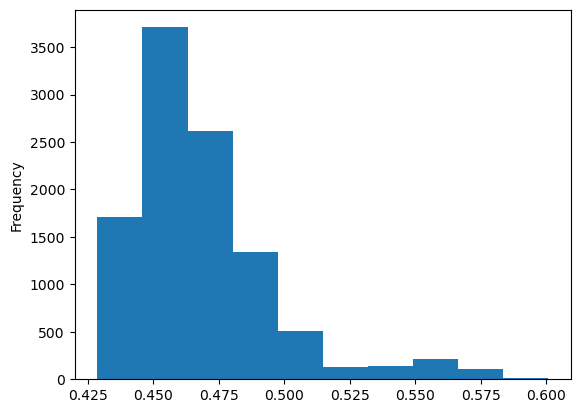

In [12]:
X['pred_AD_score'].plot(kind='hist')

In [57]:
half_anomalies = pd.DataFrame(X.loc[10379]).T

In [58]:
half_anomalies

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
10379,7.302683,8.374696,8.246338,5.328242,4.184045,6.072476,1.0,0.528928


In [59]:
bottom_anomalies = X.loc[(X['pred_AD_score']>0.5)].sort_values(by='pred_AD_score', ascending=False).tail(10)
top_anomalies = X.loc[(X['pred_AD_score']>0.5)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [60]:
top_normal = X.loc[(X['pred_AD_score']<0.5)].sort_values(by='pred_AD_score', ascending=False).tail(10)
bottom_normal = X.loc[(X['pred_AD_score']<0.5)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [61]:
top_anomalies

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
10393,10.520659,11.926523,6.724538,2.597032,7.378280,2.729952,1,0.600772
10497,10.973562,10.852197,7.449970,5.299841,6.433465,8.055351,1,0.590321
10305,10.190464,8.535641,7.177566,7.322949,7.530117,7.019877,1,0.589483
10302,10.755843,11.165199,9.495105,3.535526,5.483043,3.640112,1,0.587862
10244,8.040616,10.826473,9.427343,4.023640,6.930312,7.060886,1,0.587858
10255,11.573721,9.692835,8.302404,4.671748,5.921651,7.613669,1,0.587136
10284,9.384095,9.502645,8.545817,6.961302,7.286270,3.677363,1,0.586819
10059,11.657260,11.292205,7.841422,3.685762,6.244080,6.037636,1,0.585967
10297,9.744275,9.917414,8.817439,3.861097,7.427800,6.759580,1,0.585951
10191,9.042968,10.654264,9.612500,4.487461,4.092246,7.711690,1,0.584907


In [62]:
k = 20
acme_ifo = ACME(model = if_model, target = 'AD_score', K=k, task='ad', score_function=score_function, features=features)
acme_ifo = acme_ifo.explain(X[features], robust = True)

In [63]:
acme_ifo.feature_importance()

,importance
feature,
f3,0.014677
f1,0.013577
f2,0.007891
f4,0.006236
f5,0.004819
f6,0.004656


In [64]:
acme_local = acme_ifo.explain_local(X[features].loc[half_anomalies.index[-1]])

In [65]:
acme_local.summary_table(local=True)

,quantile,original,type_feature,predict,baseline_prediction,effect,baseline_quantile,class,importance
feature,,,,,,,,,
f1,0.942667,7.302683,numeric,0.528928,0.528928,0.000000,0.942667,None,0.003664
f1,0.050000,3.395035,numeric,0.535556,0.528928,0.006628,0.942667,None,0.003664
f1,0.100000,3.749650,numeric,0.532118,0.528928,0.003190,0.942667,None,0.003664
f1,0.150000,4.003500,numeric,0.526334,0.528928,-0.002595,0.942667,None,0.003664
f1,0.200000,4.197509,numeric,0.525868,0.528928,-0.003060,0.942667,None,0.003664
...,...,...,...,...,...,...,...,...,...
f6,0.750000,5.673818,numeric,0.521525,0.528928,-0.007403,0.860762,None,0.005269
f6,0.800000,5.845995,numeric,0.526398,0.528928,-0.002531,0.860762,None,0.005269
f6,0.850000,6.027445,numeric,0.526024,0.528928,-0.002904,0.860762,None,0.005269


In [66]:
acme_local.feature_importance()

,importance
feature,
f3,0.014677
f1,0.013577
f2,0.007891
f4,0.006236
f5,0.004819
f6,0.004656


In [86]:
acme_local.feature_importance(local=True, weights = {'ratio':0.1,'delta':0.1,'change':0.3,'distance':0.5})

,ratio,delta,change,distance_to_change,max_score,min_score,local_score,importance
f3,0.041850,0.041850,1.0,0.077714,0.528928,0.487079,0.528928,0.769513
f2,0.021246,0.021246,0.0,1.000000,0.528928,0.507682,0.528928,0.004249
f4,0.005545,0.023012,0.0,1.000000,0.546395,0.523383,0.528928,0.002856
f6,0.009235,0.016157,0.0,1.000000,0.535850,0.519693,0.528928,0.002539
f5,0.005736,0.019387,0.0,1.000000,0.542580,0.523193,0.528928,0.002512
f1,0.004679,0.011307,0.0,1.000000,0.535556,0.524249,0.528928,0.001599


In [88]:
acme_local.feature_importance(local=True)

Using default weights for anomaly detection feature importance


,ratio,delta,change,distance_to_change,max_score,min_score,local_score,importance
f3,0.041850,0.041850,1.0,0.077714,0.528928,0.487079,0.528928,0.505382
f2,0.021246,0.021246,0.0,1.000000,0.528928,0.507682,0.528928,0.010623
f4,0.005545,0.023012,0.0,1.000000,0.546395,0.523383,0.528928,0.008012
f5,0.005736,0.019387,0.0,1.000000,0.542580,0.523193,0.528928,0.006963
f6,0.009235,0.016157,0.0,1.000000,0.535850,0.519693,0.528928,0.006694
f1,0.004679,0.011307,0.0,1.000000,0.535556,0.524249,0.528928,0.004328


In [82]:
acme_local.summary_plot(local=True)

In [69]:
acme_local.feature_exploration('f1',local=True)

,quantile,original,type_feature,predict,baseline_prediction,effect,baseline_quantile,class,size,importance,direction
feature,,,,,,,,,,,
f1,0.942667,7.302683,numeric,0.528928,0.528928,0.000000,0.942667,None,0.30,0.003664,anomalies
f1,0.050000,3.395035,numeric,0.535556,0.528928,0.006628,0.942667,None,0.05,0.003664,anomalies
f1,0.100000,3.749650,numeric,0.532118,0.528928,0.003190,0.942667,None,0.05,0.003664,anomalies
f1,0.150000,4.003500,numeric,0.526334,0.528928,-0.002595,0.942667,None,0.05,0.003664,anomalies
f1,0.200000,4.197509,numeric,0.525868,0.528928,-0.003060,0.942667,None,0.05,0.003664,anomalies
f1,0.250000,4.360358,numeric,0.525743,0.528928,-0.003186,0.942667,None,0.05,0.003664,anomalies
f1,0.300000,4.519078,numeric,0.525270,0.528928,-0.003658,0.942667,None,0.05,0.003664,anomalies
f1,0.350000,4.658569,numeric,0.525270,0.528928,-0.003658,0.942667,None,0.05,0.003664,anomalies
f1,0.400000,4.794849,numeric,0.524667,0.528928,-0.004261,0.942667,None,0.05,0.003664,anomalies


In [75]:
acme_local.feature_exploration('f3',local=True,plot=True)

In [80]:
acme_local.baseline_values()

,f1,f2,f3,f4,f5,f6
0,5.236343,5.230073,5.142931,4.994046,4.991018,5.001737


In [81]:
acme_local.baseline_values(local=True)

,f1,f2,f3,f4,f5,f6
10379,7.302683,8.374696,8.246338,5.328242,4.184045,6.072476


In [79]:
acme_local.summary_table(local=True)

,quantile,original,type_feature,predict,baseline_prediction,effect,baseline_quantile,class,importance
feature,,,,,,,,,
f1,0.942667,7.302683,numeric,0.528928,0.528928,0.000000,0.942667,None,0.003664
f1,0.050000,3.395035,numeric,0.535556,0.528928,0.006628,0.942667,None,0.003664
f1,0.100000,3.749650,numeric,0.532118,0.528928,0.003190,0.942667,None,0.003664
f1,0.150000,4.003500,numeric,0.526334,0.528928,-0.002595,0.942667,None,0.003664
f1,0.200000,4.197509,numeric,0.525868,0.528928,-0.003060,0.942667,None,0.003664
...,...,...,...,...,...,...,...,...,...
f6,0.750000,5.673818,numeric,0.521525,0.528928,-0.007403,0.860762,None,0.005269
f6,0.800000,5.845995,numeric,0.526398,0.528928,-0.002531,0.860762,None,0.005269
f6,0.850000,6.027445,numeric,0.526024,0.528928,-0.002904,0.860762,None,0.005269
